<a href="https://colab.research.google.com/github/Manogya-Git/AI-and-ML/blob/main/ManogyaHarshaBajracharya_Tutorial9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages (run only once)
!pip install wordcloud
!pip install nltk

In [ ]:

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.metrics import classification_report, confusion_matrix

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Optional but useful for lemmatization


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Load your dataset from Colab path
df = pd.read_csv('/content/trum_tweet_sentiment_analysis.csv')

# Preview the dataset
df.head()

,text,Sentiment
0,RT @JohnLeguizamo: #trump not draining swamp b...,0.0
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,0.0
2,Trump protests: LGBTQ rally in New York https:...,1.0
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",0.0
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,0.0


In [ ]:
print(df.columns)

Index(['text', 'Sentiment'], dtype='object')


In [ ]:
# Preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+|\#', '', text)   # Remove mentions/hashtags
    text = re.sub(r'[^\w\s]', '', text)   # Remove punctuations
    text = re.sub(r'\d+', '', text)       # Remove numbers

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

# Apply cleaning to the 'text' column
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Preview the cleaned data
df[['text', 'cleaned_text']].head()


,text,cleaned_text
0,RT @JohnLeguizamo: #trump not draining swamp b...,rt trump draining swamp taxpayer dollar trip a...
1,ICYMI: Hackers Rig FM Radio Stations To Play A...,icymi hacker rig fm radio station play antitru...
2,Trump protests: LGBTQ rally in New York https:...,trump protest lgbtq rally new york bbcworld via
3,"""Hi I'm Piers Morgan. David Beckham is awful b...",hi im pier morgan david beckham awful donald t...
4,RT @GlennFranco68: Tech Firm Suing BuzzFeed fo...,rt tech firm suing buzzfeed publishing unverif...


In [ ]:
print(df.columns)

Index(['text', 'Sentiment', 'cleaned_text'], dtype='object')


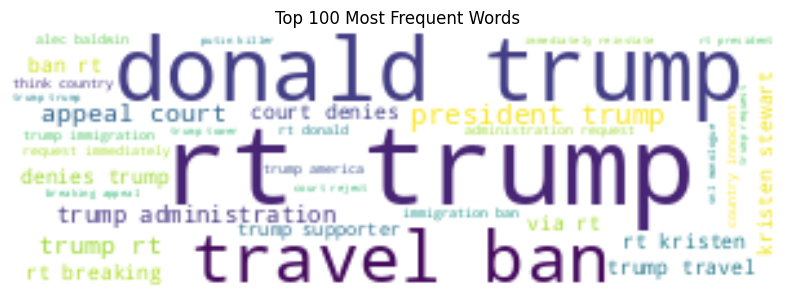

In [ ]:
# Encode labels
label_encoder = LabelEncoder()
df['sentiment_encoded'] = label_encoder.fit_transform(df['Sentiment'])

# Visualization: WordCloud
all_words = ' '.join(df['cleaned_text'])
wordcloud = WordCloud(width=300,
                      height=100,
                      background_color='white',
                      max_words=100
                     ).generate(all_words)

# Plotting the WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 Most Frequent Words')
plt.show()


In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],      # Use 'cleaned_text' for training
    df['sentiment_encoded'], # Use 'sentiment_encoded' for target labels
    test_size=0.2,           # 20% test set
    random_state=42          # For reproducibility
)

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # Only use the top 10,000 words, <OOV> for out-of-vocabulary words
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on the training set

# Convert text to sequences (turn words into integer sequences)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding: Ensure all sequences have the same length
seq_lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(seq_lengths, 95))  # Use the 95th percentile of sequence lengths

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

# Preview shapes of the padded sequences
print(f"X_train_pad shape: {X_train_pad.shape}")
print(f"X_test_pad shape: {X_test_pad.shape}")


X_train_pad shape: (49509, 16)
X_test_pad shape: (12378, 16)


In [ ]:
# Simple RNN Model
rnn_model = Sequential([
    # Embedding layer: Input dimension is 10000 (vocabulary size), output dimension is 128, input length is the max sequence length
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),

    # Simple RNN layer: 64 units
    SimpleRNN(64),

    # Output layer: Single neuron with sigmoid activation (for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
rnn_model.compile(
    loss='binary_crossentropy',  # Binary classification loss function
    optimizer='adam',            # Adam optimizer
    metrics=['accuracy']         # Track accuracy during training
)

# Model summary to view architecture
rnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# LSTM Model
lstm_model = Sequential([
    # Embedding layer: Input dimension is 10000 (vocabulary size), output dimension is 128, input length is the max sequence length
    Embedding(input_dim=10000, output_dim=128, input_length=max_len),

    # LSTM layer: 64 units
    LSTM(64),

    # Output layer: Single neuron with sigmoid activation (for binary classification)
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(
    loss='binary_crossentropy',  # Binary classification loss function
    optimizer='adam',            # Adam optimizer
    metrics=['accuracy']         # Track accuracy during training
)

# Model summary to view architecture
lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train RNN model
rnn_history = rnn_model.fit(
    X_train_pad, y_train,                          # Training data and labels
    epochs=10,                                     # Number of epochs
    batch_size=64,                                 # Batch size
    validation_split=0.2,                          # Use 20% of data for validation
    callbacks=[early_stop]                         # Early stopping callback to avoid overfitting
)

# Train LSTM model
lstm_history = lstm_model.fit(
    X_train_pad, y_train,                          # Training data and labels
    epochs=10,                                     # Number of epochs
    batch_size=64,                                 # Batch size
    validation_split=0.2,                          # Use 20% of data for validation
    callbacks=[early_stop]                         # Early stopping callback to avoid overfitting
)


Epoch 1/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8415 - loss: 0.3473 - val_accuracy: 0.9383 - val_loss: 0.1576
Epoch 2/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9767 - loss: 0.0648 - val_accuracy: 0.9157 - val_loss: 0.2061
Epoch 3/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9906 - loss: 0.0302 - val_accuracy: 0.9318 - val_loss: 0.2106
Epoch 4/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9941 - loss: 0.0197 - val_accuracy: 0.9374 - val_loss: 0.2580
Epoch 1/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.8407 - loss: 0.3588 - val_accuracy: 0.9373 - val_loss: 0.1581
Epoch 2/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9574 - loss: 0.1110 - val_accuracy: 0.9440 - val_loss: 0.1558
Epoch 3/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9768 - loss: 0.0628 - val_accuracy: 0.9460 - val_loss: 0.1609
Epoch 4/10
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9871 - loss: 0.0375 - val_accuracy: 0.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# --- RNN Evaluation ---
rnn_preds = (rnn_model.predict(X_test_pad) > 0.5).astype("int32")

print("Simple RNN Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, rnn_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, rnn_preds))


# --- LSTM Evaluation ---
lstm_preds = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")

print("\nLSTM Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, lstm_preds))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, lstm_preds))


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Simple RNN Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      8756
           1       0.90      0.89      0.89      3621
           2       0.00      0.00      0.00         1

    accuracy                           0.94     12378
   macro avg       0.62      0.61      0.62     12378
weighted avg       0.94      0.94      0.94     12378


Confusion Matrix:
[[8404  352    0]
 [ 416 3205    0]
 [   1    0    0]]
 28/387 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

LSTM Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      8756
           1       0.90      0.91      0.90      3621
           2       0.00      0.00      0.00         1

    accuracy                           0.94     12378
   macro avg       0.62      0.62      0.62     12378
weighted avg       0.94      0.94      0.94     12378


Confusion Matrix:
[[8389  367    0]
 [ 334 3287    0]
 [   1    0    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


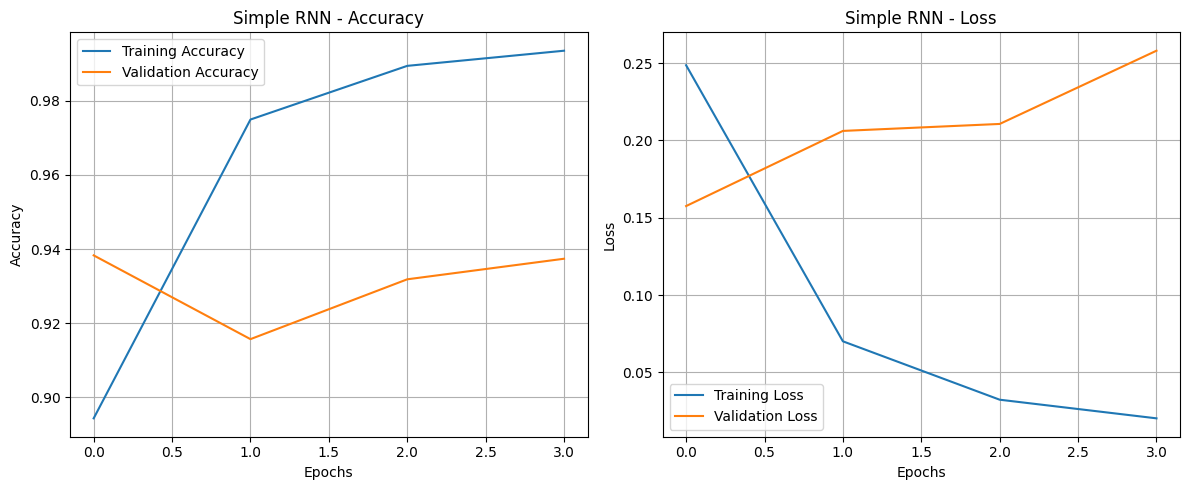

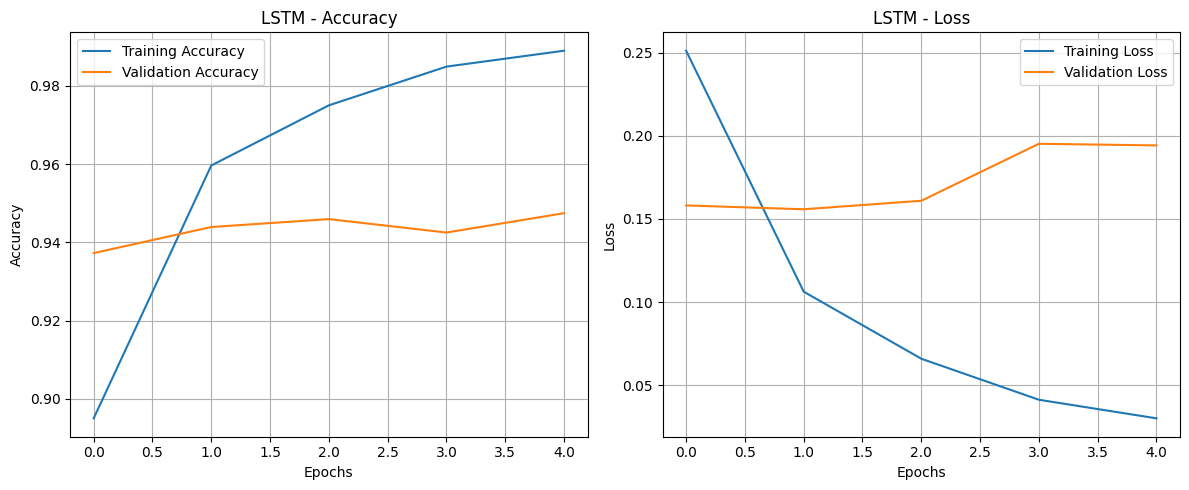

In [ ]:
# Function to plot training history
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training history for both models
plot_history(rnn_history, "Simple RNN")
plot_history(lstm_history, "LSTM")


In [ ]:
# Save the trained models in HDF5 format
rnn_model.save('/content/rnn_model.h5')
lstm_model.save('/content/lstm_model.h5')

print("Models saved successfully in /content/")


Models saved successfully in /content/


In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.7/322.7 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.5 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import gradio as gr
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Ensure NLTK resources are downloaded (run if not already done earlier)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Preprocessing function (same used during training)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'@\w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

# Prediction function using the trained LSTM model
def predict_sentiment(text):
    # Clean and tokenize
    cleaned = preprocess_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')

    # Get prediction
    prediction = lstm_model.predict(padded)[0][0]
    sentiment = "Positive 😀" if prediction > 0.5 else "Negative 😞"

    return f"Sentiment: {sentiment} (Confidence: {prediction:.2f})"

# Gradio Interface
interface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=3, placeholder="Enter a tweet..."),
    outputs="text",
    title="Trump Tweet Sentiment Analyzer",
    description="Paste a tweet or any text to analyze sentiment using an LSTM model trained on Trump tweets."
)

# Launch with public link
interface.launch(share=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc05518d3d8e67abf0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
